In [10]:
"""
GP emulation
"""
##### Packages ###############
import numpy as np  
import matplotlib.pylab as plt
import time
import pickle
import os
from sklearn.decomposition import PCA
import GPy

###### astropy for fits reading #######
from astropy.io import fits as pf
import astropy.table


In [2]:
############################# PARAMETERS ##############################

dataDir = "./Data/" ## Data folder
modelDir = "./Models/" ## Data folder
plotsDir = "./Plots/" ## Data folder

nRankMax = [4, 8, 12, 16, 32, 48][2]  ## Number of basis vectors in truncated PCA
## Increasing nRankMax will increase emulation precision (asymptotically), but reduce the speed

del_idx = [23, 54, 89, 12]  ## Random holdouts (not used in training, reserved for validation) 


############################# PARAMETERS ##############################

fitsfileIn = dataDir + "2ndpass_vals_for_test.fits"   ## Input fits file


0 0
1 0
1 1
2 0
2 1
2 2
3 0
3 1
3 2
3 3


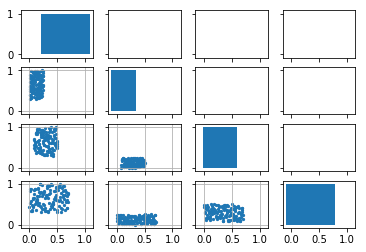

In [3]:
### 4 parameters: RHO, SIGMA, TAU, SSPT ###

Allfits = pf.open(fitsfileIn)
AllData = astropy.table.Table(Allfits[1].data)

parameter_array = np.array([AllData['RHO'], AllData['SIGMA_LAMBDA'], AllData['TAU'],
                            AllData['SSPT']]).T


def plot_params(lhd):
    f, a = plt.subplots(lhd.shape[1], lhd.shape[1], sharex=True, sharey=True)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.rcParams.update({'font.size': 8})

    for i in range(lhd.shape[1]):
        for j in range(i + 1):
            print(i, j)
            if (i != j):
                a[i, j].scatter(lhd[:, i], lhd[:, j], s=5)
                a[i, j].grid(True)
            else:
                # a[i,i].set_title(AllLabels[i])
                # a[i, i].text(0.4, 0.4, AllLabels[i], size = 'xx-large')
                hist, bin_edges = np.histogram(lhd[:, i], density=True, bins=64)
                # a[i,i].bar(hist)
                a[i, i].bar(bin_edges[:-1], hist / hist.max(), width=0.2)
                # plt.xlim(0, 1)
                # plt.ylim(0, 1)

    plt.show()


plot_params(parameter_array[:, :])


pvec = (AllData['PVEC'])[:, 1:]  # .newbyteorder('S')
# print(  np.unique( np.argwhere( np.isnan(pvec) )[:,0]) )

## There's an issue with 61st entry in the data
## right now i'm deleting the 61st value (both pvec and corresponding parameter values)
pvec_all = np.delete(pvec, (61), axis=0)
parameter_array_all = np.delete(parameter_array, (61), axis=0)



## Removing hold-out test points
parameter_array = np.delete(parameter_array_all, del_idx, axis=0)
pvec = np.delete(pvec_all, del_idx, axis=0)

In [4]:
pvec.shape

(123, 99)

In [5]:
########################### PCA ###################################
# set up pca compression
from sklearn.decomposition import PCA


def PCA_compress(x, nComp):
    # x is in shape (nCosmology, nbins)
    pca_model = PCA(n_components=nComp)
    principalComponents = pca_model.fit_transform(x)
    pca_bases = pca_model.components_

    print("original shape:   ", x.shape)
    print("transformed shape:", principalComponents.shape)
    print("bases shape:", pca_bases.shape)

    import pickle
    pickle.dump(pca_model, open(modelDir + 'PCA_model' + str(nRankMax), 'wb'))

    return pca_model, np.array(principalComponents), np.array(pca_bases)


######################## GP FITTING ################################

## Build GP models
# This is evaluated only once for the file name. GP fitting is not required if the file exists.

def GPy_fit(parameter_array, weights, fname= modelDir + 'GPy_model'):
    kern = GPy.kern.Matern52(np.shape(parameter_array)[1], 0.1)
#     m1 = GPy.models.GPRegression(parameter_array, weights, kernel=kern)
    m1 = GPy.models.GPRegression(parameter_array, weights)

#     m1.Gaussian_noise.variance.constrain_fixed(1e-16)
    m1.optimize(messages=True)
    m1.save_model(fname + str(nRankMax), compress=True, save_data=True)

In [6]:
######################## GP PREDICTION FUNCTIONS ###############################

def GPy_predict(para_array):
    m1p = m1.predict(para_array)  # [0] is the mean and [1] the predictive
    W_predArray = m1p[0]
    W_varArray = m1p[1]
    return W_predArray, W_varArray


def Emu(para_array):
    if len(para_array.shape) == 1:
        W_predArray, _ = GPy_predict(np.expand_dims(para_array, axis=0))
        x_decoded = pca_model.inverse_transform(W_predArray)
        return x_decoded[0]

    else:
        W_predArray, _ = GPy_predict(para_array)
        x_decoded = pca_model.inverse_transform(W_predArray)
        return x_decoded.T

In [7]:
pca_model, pca_weights, pca_bases = PCA_compress(pvec, nComp=nRankMax)
GPy_fit(parameter_array, pca_weights)

original shape:    (123, 99)
transformed shape: (123, 12)
bases shape: (12, 99)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Time per emulation 0.00097  s
Time per emulation 0.00081  s
Time per emulation 0.00095  s
Time per emulation 0.00052  s


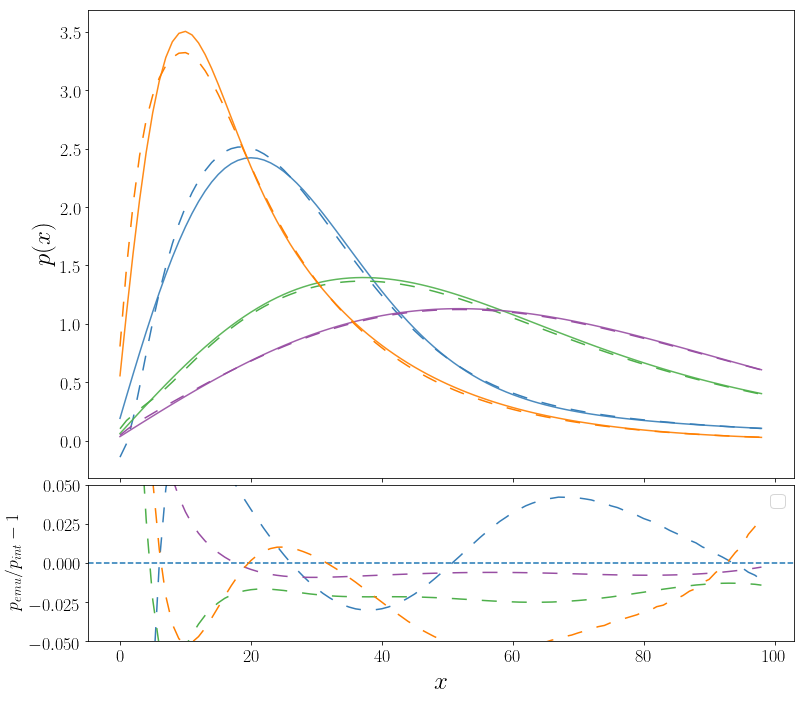

In [8]:
#### GP POSTERIOR DRAWS and PCA RECONSTRUCTIONS ######

# m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model_rank' +str(nRankMax)+ '.zip')
# pca_model = pickle.load(open(modelDir + 'PCA_model_rank'+str(nRankMax), 'rb'))

m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model'+ str(nRankMax) +'.zip')
pca_model = pickle.load(open(modelDir + 'PCA_model' + str(nRankMax), 'rb'))


rad = np.arange(0, np.shape(pvec)[1])

plt.rc('text', usetex=True)  # Slower
plt.rc('font', size=18)  # 18 usually

plt.figure(999, figsize=(14, 12))
from matplotlib import gridspec

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs.update(hspace=0.02, left=0.2, bottom=0.15)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.set_ylabel(r'$p(x)$', fontsize=25)

ax1.axhline(y=0, ls='dashed')
# ax1.axhline(y=-1e-6, ls='dashed')
# ax1.axhline(y=1e-6, ls='dashed')

ax1.set_xlabel(r'$x$', fontsize=25)

# ax0.set_yscale('log', basey=10)
# ax0.set_xscale('log', basex=10)
# ax1.set_xscale('log', basex=10)

ax1.set_ylabel(r'$p_{emu}/p_{int} - 1$', fontsize = 18)
ax1.set_ylim(-5e-2, 5e-2)


# ax0.plot(rad, pvec.T, alpha=0.1, color='k')
del_idx = [0, 1, 2, 3]
color_id = 0
for x_id in del_idx:
    color_id = color_id + 1
    time0 = time.time()
#     x_decoded_new = Emu(parameter_array_all[x_id], PCAmodel='PCA_model', GPmodel='GPy_model')
    x_decoded_new = Emu(parameter_array_all[x_id])

    time1 = time.time()
    print('Time per emulation %0.5f' % (time1 - time0), ' s')

    ax0.plot(rad, x_decoded_new, alpha=1.0, lw = 1.5, ls='--', label='emu', dashes=(10, 10), color=plt.cm.Set1(color_id))

    x_test = pvec_all[x_id]
    ax0.plot(rad, x_test, alpha=0.9, label='real', color=plt.cm.Set1(color_id))

    ax1.plot(rad, (x_decoded_new) / (x_test) - 1, ls='--', dashes=(10, 10), color=plt.cm.Set1(color_id))

    plt.legend()


ax0.set_xticklabels([])
plt.savefig(plotsDir + 'Pemu_rank' +str(nRankMax) + '.pdf', figsize=(28, 24), bbox_inches="tight")
plt.show()

In [9]:
######### TEMPLATE FOR MCMC LIKELIHOOD FUNCTION #######################
# For emcee

def lnlike(theta, x, y, yerr):
    p1, p2, p3, p4 = theta
    new_params = np.array([p1, p2, p3, p4])    

    model = Emu(new_params)
    return -0.5 * (np.sum(((y - model) / yerr) ** 2.))
